# NLP - Text Classification using LSTM

<a href="https://github.com/AayushSaxena08/Text_Classification_using_LSTM" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# importing dependancies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import re

print("Tensorflow Version",tf.__version__)

[nltk_data] Downloading package stopwords to /root/nltk_data...


Tensorflow Version 2.9.2


[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
# Loading the data

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data.csv",encoding='latin',header=None)
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## Data Preprocessing

In [4]:
df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
df.head()

,sentiment,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


We are going to train only on text to classify its sentiment. So we can ditch the rest of the useless columns.

In [5]:
df = df.drop(['id', 'date', 'query', 'user_id'], axis=1)
df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [6]:
df["sentiment"].value_counts()

0    800000
4    800000
Name: sentiment, dtype: int64

In [7]:
sentiment = {0:"Negative",4:"Positive"}
def decoder(label):
  return sentiment[label]
df.sentiment = df.sentiment.apply(lambda x: decoder(x))
df.head()

,sentiment,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."


Text(0.5, 1.0, 'Sentiment Data Distribution')

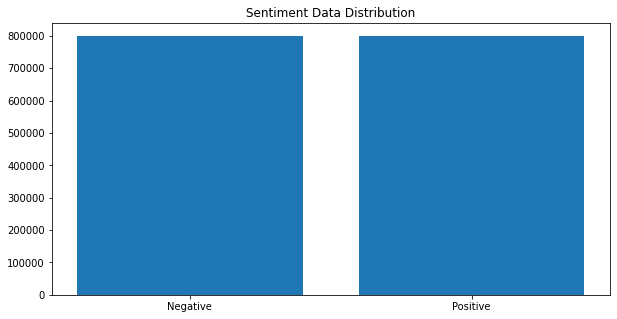

In [8]:
val_count = df["sentiment"].value_counts()

plt.figure(figsize=(10,5))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

In [9]:
df.head(200).sentiment.value_counts()

Negative    200
Name: sentiment, dtype: int64

The rows are not shuffled. First 8 lac rows are for negative sentiment and rest 8 lacs are positive, so we have to shuffle the rows. 

We are giving random indexes to the rows 

In [10]:
import random
random_idx_list = [random.randint(1,len(df.text)) for i in range(10)]
df.loc[random_idx_list,:].head(10)

,sentiment,text
564997,Negative,http://twitpic.com/7m9ms - Bonnaroo I MISS YOU
769064,Negative,"however, i'm more sick than ever! think i am g..."
135863,Negative,@vickytcobra Aw! Take care of yourself. Hope ...
645786,Negative,"sam says hi. sam the cat. actually, that's a l..."
1057671,Positive,s dancing round the kitchen in an attempt to b...
527219,Negative,@mgregoryw I know change it to what?
1345871,Positive,Just got my diploma
1517302,Positive,let's all think about @randomflowers who is to...
1447378,Positive,@Cari_tx I can tell u r a big Twilight fan
316547,Negative,"@zoernert #iod2009 Yes, got my poken but is no..."


The text column is very dirty to process because we have a lot of punctuation and other words without any contextual meaning. So it is necessary to get rid of them.

## Text Preprocessing

In [11]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

def preprocess(text,stem=False):
  text = re.sub(text_cleaning_re, " ", str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [12]:
df.text = df.text.apply(lambda x: preprocess(x))

In [13]:
df.head()

,sentiment,text
0,Negative,awww bummer shoulda got david carr third day
1,Negative,upset update facebook texting might cry result...
2,Negative,dived many times ball managed save 50 rest go ...
3,Negative,whole body feels itchy like fire
4,Negative,behaving mad see


Now the data is clean. Before proceeding, let's see some visualizations of it.

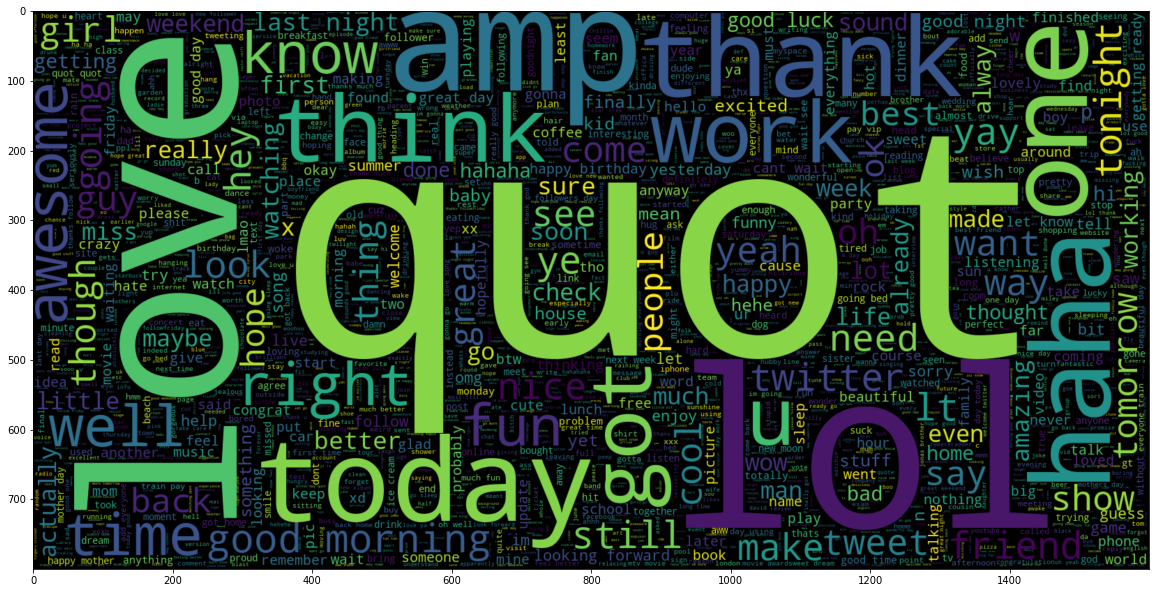

In [14]:
# Positive words

from wordcloud import WordCloud
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'Positive'].text))
plt.imshow(wc,interpolation = 'bilinear')

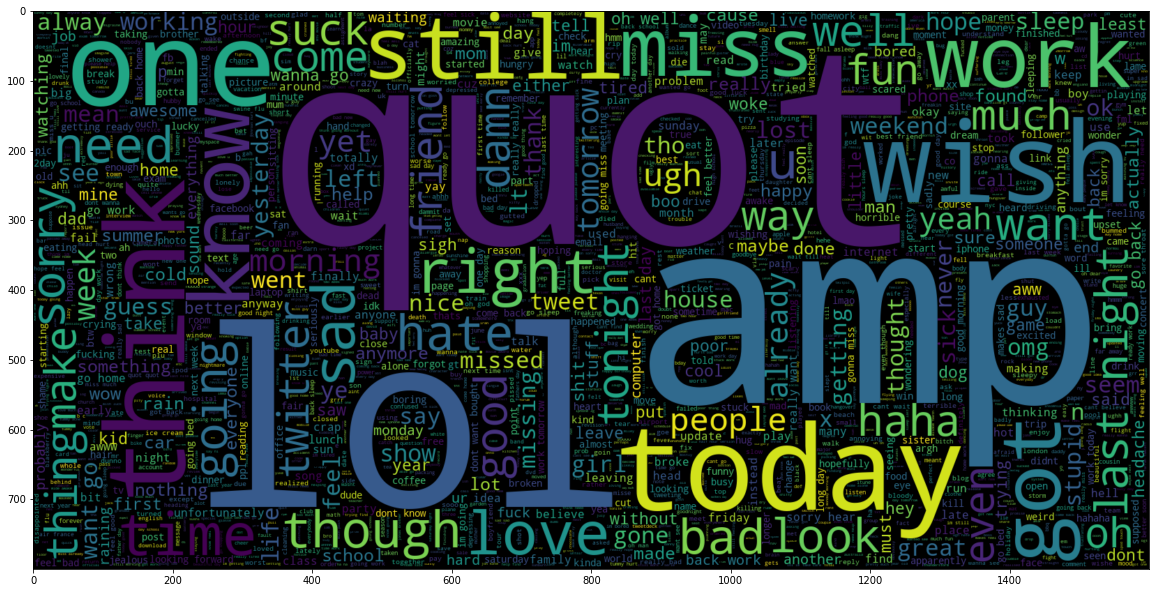

In [15]:
## Negative words

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'Negative'].text))
plt.imshow(wc , interpolation = 'bilinear')

### Train Test Split

In [19]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30

In [16]:
train_data, test_data = train_test_split(df,test_size=0.2,random_state=7)
print("Train Data Size :", len(train_data))
print("Test Data Size  :", len(test_data))

Train Data Size : 1280000
Test Data Size  : 320000


`train_test_split` will shuffle the dataset and split it to gives training and testing dataset. It's important to shuffle our dataset before training.

In [17]:
train_data.head(10)

,sentiment,text
23786,Negative,need friends
182699,Negative,im trying call impossible
476661,Negative,good pace going 3k 13 min missed 5k turn ended...
1181490,Positive,u gonna shows ny soon luv see u live
878773,Positive,hell yea get em tattoos ink free wish parents ...
130866,Negative,yeah need 2 see ur mom calls back first rememb...
1235876,Positive,sounds like cup tea sign
717314,Negative,tired want sleep wtf
969880,Positive,amazing wish
748698,Negative,thank god wkrn abc affiliate nashville back mi...


### Tokenization

In [18]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 290575


Now we got a `tokenizer` object, which can be used to covert any word into a Key in dictionary (number).

Since we are going to build a sequence model. We should feed in a sequence of numbers to it. And also we should ensure there is no variance in input shapes of sequences. It all should be of same lenght. But texts in tweets have different count of words in it. To avoid this, we seek a little help from pad_sequence to do our job. It will make all the sequence in one constant length `MAX_SEQUENCE_LENGTH`.

In [22]:
from keras_preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text), maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text), maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (1280000, 30)
Testing X Shape: (320000, 30)


In [23]:
labels = train_data.sentiment.unique().tolist()

### Label Encoding

In [24]:
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:",y_train.shape)
print("y_test shape:",y_test.shape)

y_train shape: (1280000, 1)
y_test shape: (320000, 1)


### Word Embeddings

In this notebook, I use **GloVe Embedding from Stanford AI** which can be found <a href = "https://nlp.stanford.edu/projects/glove/">here</a>

In [25]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2023-02-07 12:28:44--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-02-07 12:28:44--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-02-07 12:28:45--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [26]:
GLOVE_EMB = '/content/glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10 
MODEL_PATH = '/content/drive/MyDrive/Colab Notebooks/text_classification_model.hdf5'

In [27]:
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [28]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [30]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

## Model Training - LSTM

In [31]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

In [32]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

### Optimization Algorithm

This notebook uses Adam, optimization algorithm for Gradient Descent.

### Callbacks

Callbacks are special functions which are called at the end of an epoch. We can use any functions to perform specific operation after each epoch. 

- LRScheduler 
- ModelCheckPoint

In [33]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy', metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

In [35]:
print("Training on GPU...") if tf.config.list_physical_devices('GPU') else print("Training on CPU...")

Training on CPU...


Let's start training... It takes a heck of a time if training in CPU, be sure your GPU turned on... May the CUDA Cores be with you....

In [ ]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

Epoch 1/10
1250/1250 [==============================] - 1701s 1s/step - loss: 0.5191 - accuracy: 0.7394 - val_loss: 0.4811 - val_accuracy: 0.7663 - lr: 0.0010
Epoch 2/10
1250/1250 [==============================] - 1656s 1s/step - loss: 0.4873 - accuracy: 0.7623 - val_loss: 0.4711 - val_accuracy: 0.7730 - lr: 0.0010
Epoch 3/10
1250/1250 [==============================] - 1570s 1s/step - loss: 0.4772 - accuracy: 0.7689 - val_loss: 0.4660 - val_accuracy: 0.7761 - lr: 0.0010
Epoch 4/10
 892/1250 [====================>.........] - ETA: 7:14 - loss: 0.4709 - accuracy: 0.7729

## Model Evaluation

In [ ]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

The model will output a prediction score between 0 and 1. We can classify two classes by defining a threshold value for it. In our case, I have set 0.5 as THRESHOLD value, if the score above it. Then it will be classified as **POSITIVE** sentiment.

### Confusion Matrix


In [ ]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

In [ ]:
cnf_matrix = confusion_matrix(test_data.sentiment.to_list(), y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=test_data.sentiment.unique(), title="Confusion matrix")
plt.show()

## Classification scores

In [ ]:
print(classification_report(list(test_data.sentiment), y_pred_1d))